<a href="https://colab.research.google.com/github/gromicho/Heuristics/blob/main/notebooks/04/09-shortest-path-road-networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```{index} single: application; shortest path
```
```{index} networkx
```
```{index} network optimization
```
```{index} pandas dataframe
```

# Extra material: Shortest path problem in real life


In [1]:
import sys
if "google.colab" in sys.modules:
    %pip install "numpy<2"
    %pip install pandana
    %pip install osmnx
    %pip install osmnet
    %pip install mapclassify

  Using cached pandana-0.7.tar.gz (295 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandana: filename=pandana-0.7-cp312-cp312-linux_x86_64.whl size=2025928 sha256=f5a41598ff3db2337cb3cc2a065a3d81f81e9161496d7c8f3748d59a34f62df7
  Stored in directory: /root/.cache/pip/wheels/7d/a7/da/59a901192593b38f134150a3e50d9c2b99353a81086dd5fc62
Successfully built pandana


# Introduction

Google brought with [maps]( https://www.google.com/maps) the world to our screens, including accurate geocoding and routing for several modalities. For the most, the usage of [maps]( https://www.google.com/maps) is interactive. As data and analytics professionals we often need a programmatically support for the services that [maps]( https://www.google.com/maps) offer us, preferably free. It also offers a plethora of [development support](https://developers.google.com/), but unfortunately most is paid. That is even more so for [maps]( https://developers.google.com/maps/documentation).

## Some background information and history
[Geoff Boeing]( https://geoffboeing.com/about/) is a true leader in demystifying urban data analytics, with a strong emphasis on street networks. His [peer reviewed publications]( https://geoffboeing.com/publications/) are open and accompanied by usable demonstrations using his own [OSMnx]( https://geoffboeing.com/2018/03/osmnx-features-roundup/) package.
Professor [Peter Sanders]( https://algo2.iti.kit.edu/english/sanders.php), see also his [Wikipedia]( https://en.wikipedia.org/wiki/Peter_Sanders_(computer_scientist)) page, has moved his interests to other areas but his [route planning]( http://algo2.iti.kit.edu/routeplanning.php) project shaped the world of truly scalable road routing algorithms.
From his alumni I distinguish two persons:
 * [Dominik Schultes](http://algo2.iti.kit.edu/schultes/) who won the [DIMACS challenge on shortest paths]( http://www.diag.uniroma1.it//challenge9/data/tiger/) and made it to the [Scientific American top 50]( https://www.scientificamerican.com/article/sciam-50-the-fastest-way/). Before Dominik’s research scalable shortest paths on large national road networks where heuristics, now they are exact and can be computed at world scale.
 * [Dennis Luxen]( http://algo2.iti.kit.edu/english/luxen.php) for creating https://github.com/Project-OSRM/osrm-backend which offers a free, scalable, implementation of [contraction hierarchies]( https://en.wikipedia.org/wiki/Contraction_hierarchies).

Finally, I mention [Fletcher Foti]( https://fletcherfoti.weebly.com/) who gave us [pandana]( http://udst.github.io/pandana/).



## Geocoding and map visualization

The world is mapped with the [geographic coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system) but we have difficulties remembering [latitudes]( https://en.wikipedia.org/wiki/Latitude) and [longitudes]( https://en.wikipedia.org/wiki/Longitude). We learn and remember the world better from addresses.

In [7]:
import osmnx as ox
import osmnet as osm
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import geopy
import folium
import networkx as nx
from IPython.display import display

In [8]:
def FreeLocator():
    return geopy.Photon(user_agent="myGeocoder")


def locate_geopy(description):
    location = FreeLocator().geocode(description)
    if location is not None:
        return location.latitude, location.longitude
    return None, None


pd.options.display.float_format = "{:.6f}".format

data = {
    "address": [
        "Centraal Station",
        "VU Hoofdgebouw",
        "Amsterdam Business School",
        "University of Amsterdam",
        "Johan Cruijff ArenA",
        "Ziggo Dome",
    ],
    "color": ["blue", "black", "orange", "green", "red", "purple"],
}

df = pd.DataFrame(data)
df["city"] = "Amsterdam"
df["country"] = "NL"

locations = [
    locate_geopy(",".join(row[["address", "city", "country"]]))
    for _, row in df.iterrows()
]
df["lat"] = [loc[0] for loc in locations]
df["lon"] = [loc[1] for loc in locations]
display(df)

Amsterdam = FreeLocator().geocode("Amsterdam, NL")

Map = folium.Map(location=(Amsterdam.latitude, Amsterdam.longitude), zoom_start=13)

for _, row in df.iterrows():
    folium.Marker(
        (row.lat, row.lon), icon=folium.Icon(color=row.color), tooltip=row.address
    ).add_to(Map)
Map

,address,color,city,country,lat,lon
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.314353,4.942843
5,Ziggo Dome,purple,Amsterdam,NL,52.313407,4.937123


In [9]:
ox.settings.log_console = True
ox.settings.use_cache = True

In [10]:
%%time
G_walk = ox.graph_from_place('Amsterdam, NL', network_type='walk')

CPU times: user 1min, sys: 939 ms, total: 1min 1s
Wall time: 1min 30s


In [11]:
print(G_walk.number_of_nodes(), G_walk.number_of_edges())

48075 134024


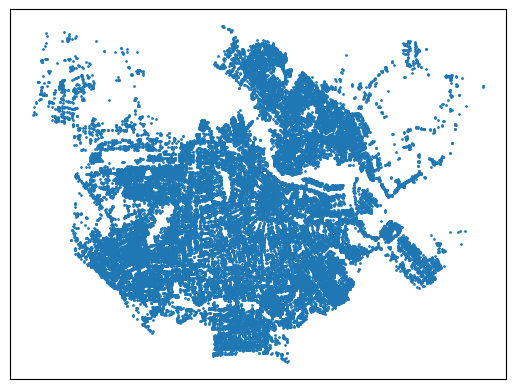

In [13]:
node_positions = {
    node: (data["x"], data["y"]) for node, data in G_walk.nodes(data=True)
}
nx.draw_networkx_nodes(G_walk, pos=node_positions, node_size=1)

In [14]:
df["osmnx"] = ox.distance.nearest_nodes(G_walk, df.lon, df.lat)
df

,address,color,city,country,lat,lon,osmnx
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581,5629072001
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901,294648098
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718,46356661
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804,8121695895
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.314353,4.942843,2680554148
5,Ziggo Dome,purple,Amsterdam,NL,52.313407,4.937123,2680554148


In [15]:
%time route = nx.shortest_path(G_walk,df.iloc[0].osmnx,df.iloc[1].osmnx,weight='length')
print(route)

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 131 ms
[5629072001, 5629072000, 5629071975, 4239313191, 4239313081, 4239313075, 4239312638, 4239312162, 6358902057, 11420679545, 11420679544, 11420679542, 3175727845, 10633464529, 10633464528, 9959600348, 9959600349, 9959600284, 9971788079, 9971788077, 9971788076, 9817686663, 9817686662, 10208267268, 6841663011, 6841663007, 6841654478, 8608994367, 8072948169, 6841636869, 6841636868, 12316269234, 6841645041, 6841680457, 6841680467, 6841680468, 6841680481, 8036446640, 8036446607, 8036446617, 8036446623, 8036446626, 9140788997, 8036446635, 8036446637, 3412535141, 3416675281, 3416675272, 3416675263, 3416675257, 6949114049, 6949114048, 10823781800, 6949114037, 6949114047, 6949114046, 5792613757, 46332984, 7191491361, 8852212652, 46331976, 46330373, 1976839698, 7191576329, 7191576325, 5805311952, 10073385072, 5805311930, 5805311950, 12343831161, 46321108, 46318613, 5805314256, 5805314261, 12241860172, 5805453836, 1342112320, 4630873

In [27]:
# explore a route interactively
route_edges = ox.routing.route_to_gdf(G_walk, route, weight='length')
route_edges.explore(tiles="cartodbpositron", style_kwds={"weight": 5})

# Dijkstra on steroids for road networks

In [54]:
nodes = pd.DataFrame.from_dict(dict(G_walk.nodes(data=True)), orient="index")
edges = nx.to_pandas_edgelist(G_walk)

In [55]:
%%time
import pandana
network = pandana.Network(nodes['x'], nodes['y'], edges['source'], edges['target'], edges[['length']],twoway=True)

CPU times: user 6 s, sys: 19.5 ms, total: 6.02 s
Wall time: 3.82 s


In [30]:
network.nodes_df.head()

,x,y
6316199,4.888396,52.370173
25596455,4.923563,52.364840
25596477,4.906097,52.367000
25645989,4.925075,52.365727
25658579,4.930425,52.364536


In [31]:
network.edges_df.head()

,from,to,length
0,6316199,46379627,42.496919
1,6316199,46389218,225.577040
2,6316199,391355271,62.907067
3,25596455,8383889398,1.791003
4,25596455,46356773,41.699822


In [32]:
df["pandana"] = network.get_node_ids(df.lon, df.lat).values
df

,address,color,city,country,lat,lon,osmnx,pandana
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581,5629072001,5629071974
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901,294648098,294648098
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718,46356661,46356661
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804,8121695895,8121695901
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.314353,4.942843,2680554148,10967577086
5,Ziggo Dome,purple,Amsterdam,NL,52.313407,4.937123,2680554148,10967577086


In [33]:
%time path_pandana = network.shortest_path(df.iloc[2].pandana, df.iloc[3].pandana)

CPU times: user 7.17 ms, sys: 953 µs, total: 8.12 ms
Wall time: 7.85 ms


In [34]:
%time path_nx = nx.shortest_path(G_walk,df.iloc[2].osmnx,df.iloc[3].osmnx,weight='length')

CPU times: user 14 ms, sys: 945 µs, total: 15 ms
Wall time: 14.9 ms


In [35]:
A = set(path_pandana)
B = set(path_nx)
(A | B) - (A & B)

{8121695895}

In [36]:
origs = [o for o in df.pandana for d in df.pandana]
dests = [d for o in df.pandana for d in df.pandana]
%time distances = network.shortest_path_lengths(origs, dests)

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.6 ms


In [37]:
import numpy as np

n = len(df)
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame(
    np.array(list(distances)).reshape(n, n), index=df.address, columns=df.address
)

address,Centraal Station,VU Hoofdgebouw,Amsterdam Business School,University of Amsterdam,Johan Cruijff ArenA,Ziggo Dome
address,,,,,,
Centraal Station,0.00,6836.32,2220.97,1462.39,6814.67,6814.67
VU Hoofdgebouw,6836.32,0.00,6215.02,5505.62,7342.21,7342.21
Amsterdam Business School,2220.97,6215.02,0.00,1861.46,5248.95,5248.95
University of Amsterdam,1462.39,5505.62,1861.46,0.00,6208.17,6208.17
Johan Cruijff ArenA,6814.67,7342.21,5248.95,6208.17,0.00,0.00
Ziggo Dome,6814.67,7342.21,5248.95,6208.17,0.00,0.00


In [38]:
np.random.seed(2023)
n = 500
sample = np.random.choice(
    np.array(network.nodes_df.index.values.tolist()), n, replace=False
)
origs = [o for o in sample for d in sample]
dests = [d for o in sample for d in sample]

In [39]:
%time distances = network.shortest_path_lengths(origs, dests)
%time table = pd.DataFrame(np.array(list(distances)).reshape(n,n),index=sample,columns=sample)

CPU times: user 8.19 s, sys: 23.5 ms, total: 8.21 s
Wall time: 4.78 s
CPU times: user 26.3 ms, sys: 30 µs, total: 26.3 ms
Wall time: 18.2 ms


In [40]:
departure = table.max(axis=1).idxmax()
arrival = table.loc[departure].idxmax()
%time path_pandana = network.shortest_path(departure, arrival)
%time path_nx = nx.shortest_path(G_walk,departure,arrival,weight='length')
A = set(path_pandana)
B = set(path_nx)
(A | B) - (A & B)

CPU times: user 6.44 ms, sys: 0 ns, total: 6.44 ms
Wall time: 6.37 ms
CPU times: user 481 ms, sys: 118 µs, total: 481 ms
Wall time: 481 ms


set()

In [41]:
%time paths = network.shortest_paths(origs,dests)

CPU times: user 18.6 s, sys: 1.1 s, total: 19.7 s
Wall time: 14 s


In [42]:
sum(map(len, paths))

37483140

In [43]:
for u, v in zip(paths[1][:-1], paths[1][1:]):
    print(G_walk.get_edge_data(u, v)[0].get("name", ""))

Retiefstraat
Retiefstraat
Retiefstraat
Retiefstraat
Retiefstraat
Cilliersstraat
Tugelaweg
Tugelaweg
Tugelaweg
Linnaeusstraat
Populierenweg
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat
Linnaeusstraat

Mauritskade
Mauritskade
Mauritskade
Alexanderplein
Alexanderplein
Alexanderplein
Alexanderplein
Alexanderplein
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Korte 's-Gravesandestraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
['Sarphatistraat', 'Frederiksplein']
Frederiksplein
Frederiksplein
Frederiksplein
Weteringsch

In [44]:
# explore a route interactively
route_edges = ox.routing.route_to_gdf(G_walk, paths[1], weight='length')
route_edges.explore(tiles="cartodbpositron", style_kwds={"color": "red", "weight": 5})